In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
from tqdm import tqdm
import cv2
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.offline as offline
from plotly.subplots import make_subplots
import random
import pandas as pd
import numpy as np
import cv2
import os
import tensorflow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *

from keras.applications.inception_v3 import preprocess_input
offline.init_notebook_mode(connected = True)

In [ ]:
class Load_Datasets():
    def __init__(self,path="/content/drive/MyDrive/eye reaction last",size_images= (350,350),gray=False):
        self.path = path
        self.gray = gray
        self.size_images = size_images
    def load_images(self,p):
        images = []
        labels = []
        for emotion in tqdm(os.listdir(p)):
            new_p = os.path.join(p,emotion)
            for image in os.listdir(new_p):
                if self.gray:
                    image = cv2.imread(os.path.join(new_p,image),cv2.IMREAD_GRAYSCALE)

                else:
                    image = cv2.imread(os.path.join(new_p,image))
                image = cv2.resize(image,self.size_images)
                images.append(image)
                labels.append(emotion)
        if self.gray:
            images = np.array(images)
            labels = np.array(labels)
            images = images.reshape(images.shape[0],images.shape[1]*images.shape[2])
            images = images.astype("float")/255

        return images,labels
    def load_data(self):
        for file in os.listdir(self.path):
            if file=="train":
                print("*"*100)
                print("Loading Training Dataset")
                train_path = os.path.join(self.path,"train")
                train_x,train_y = self.load_images(train_path)
            else:
                if file=="test":
                    print("*"*100)
                    print("Loading Testing Dataset")
                    test_path = os.path.join(self.path,"test")
                    test_x,test_y = self.load_images(test_path)
                else:
                    print("there is no train test folder")
        return train_x,train_y,test_x,test_y

In [ ]:
data = Load_Datasets()
train_x,train_y,test_x,test_y = data.load_data()

****************************************************************************************************
Loading Training Dataset


100%|██████████| 6/6 [02:57<00:00, 29.52s/it]


****************************************************************************************************
Loading Testing Dataset


100%|██████████| 6/6 [01:29<00:00, 15.00s/it]

there is no train test folder


In [ ]:
def create_dataframe(train_y,test_y):
    dist = []
    df= pd.DataFrame()
    df_test= pd.DataFrame()
    df["labels"] = train_y
    df["Type"] = "train"
    df_test["labels"] = test_y
    df_test["Type"] = "test"
    df = df.append(df_test,ignore_index = True)
    return df
df = create_dataframe(train_y,test_y)

<ipython-input-6-8d346685bb43>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
train = df[df["Type"]=="train"]
train_dist =  pd.DataFrame(train["labels"].value_counts() )
train_dist= train_dist.reset_index()

test = df[df["Type"]=="test"]
test_dist =  pd.DataFrame(test["labels"].value_counts() )
test_dist= test_dist.reset_index()
def plot_data_distribution(data,label):
    fig = make_subplots(
        rows=1, cols=2,
        column_widths=[0.5, 0.5],
        row_heights=[0.5],
        specs=[[ {"type": "pie"}, {"type": "Funnelarea"}]])


    fig.add_trace(go.Pie(
        labels=data["index"],
        values=data["labels"],
        legendgroup="group",
        textinfo='percent+label'),
        row=1, col=1)

    fig.add_trace(go.Funnelarea(
       values=data['labels'], labels=data['index'], name='Emotions data distribution',
        title = {"position": "top center",}),
                        row=1, col=2)

    fig.update_layout(height=500,width=1000, bargap=0.2,
                      margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                      title_text=f"{label} Data Distribution",
                      template="plotly_white",
                      title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
                      font=dict(color='#8a8d93'),
                      hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                      showlegend=False)
    fig.show()


In [ ]:
plot_data_distribution(train_dist,"Training")


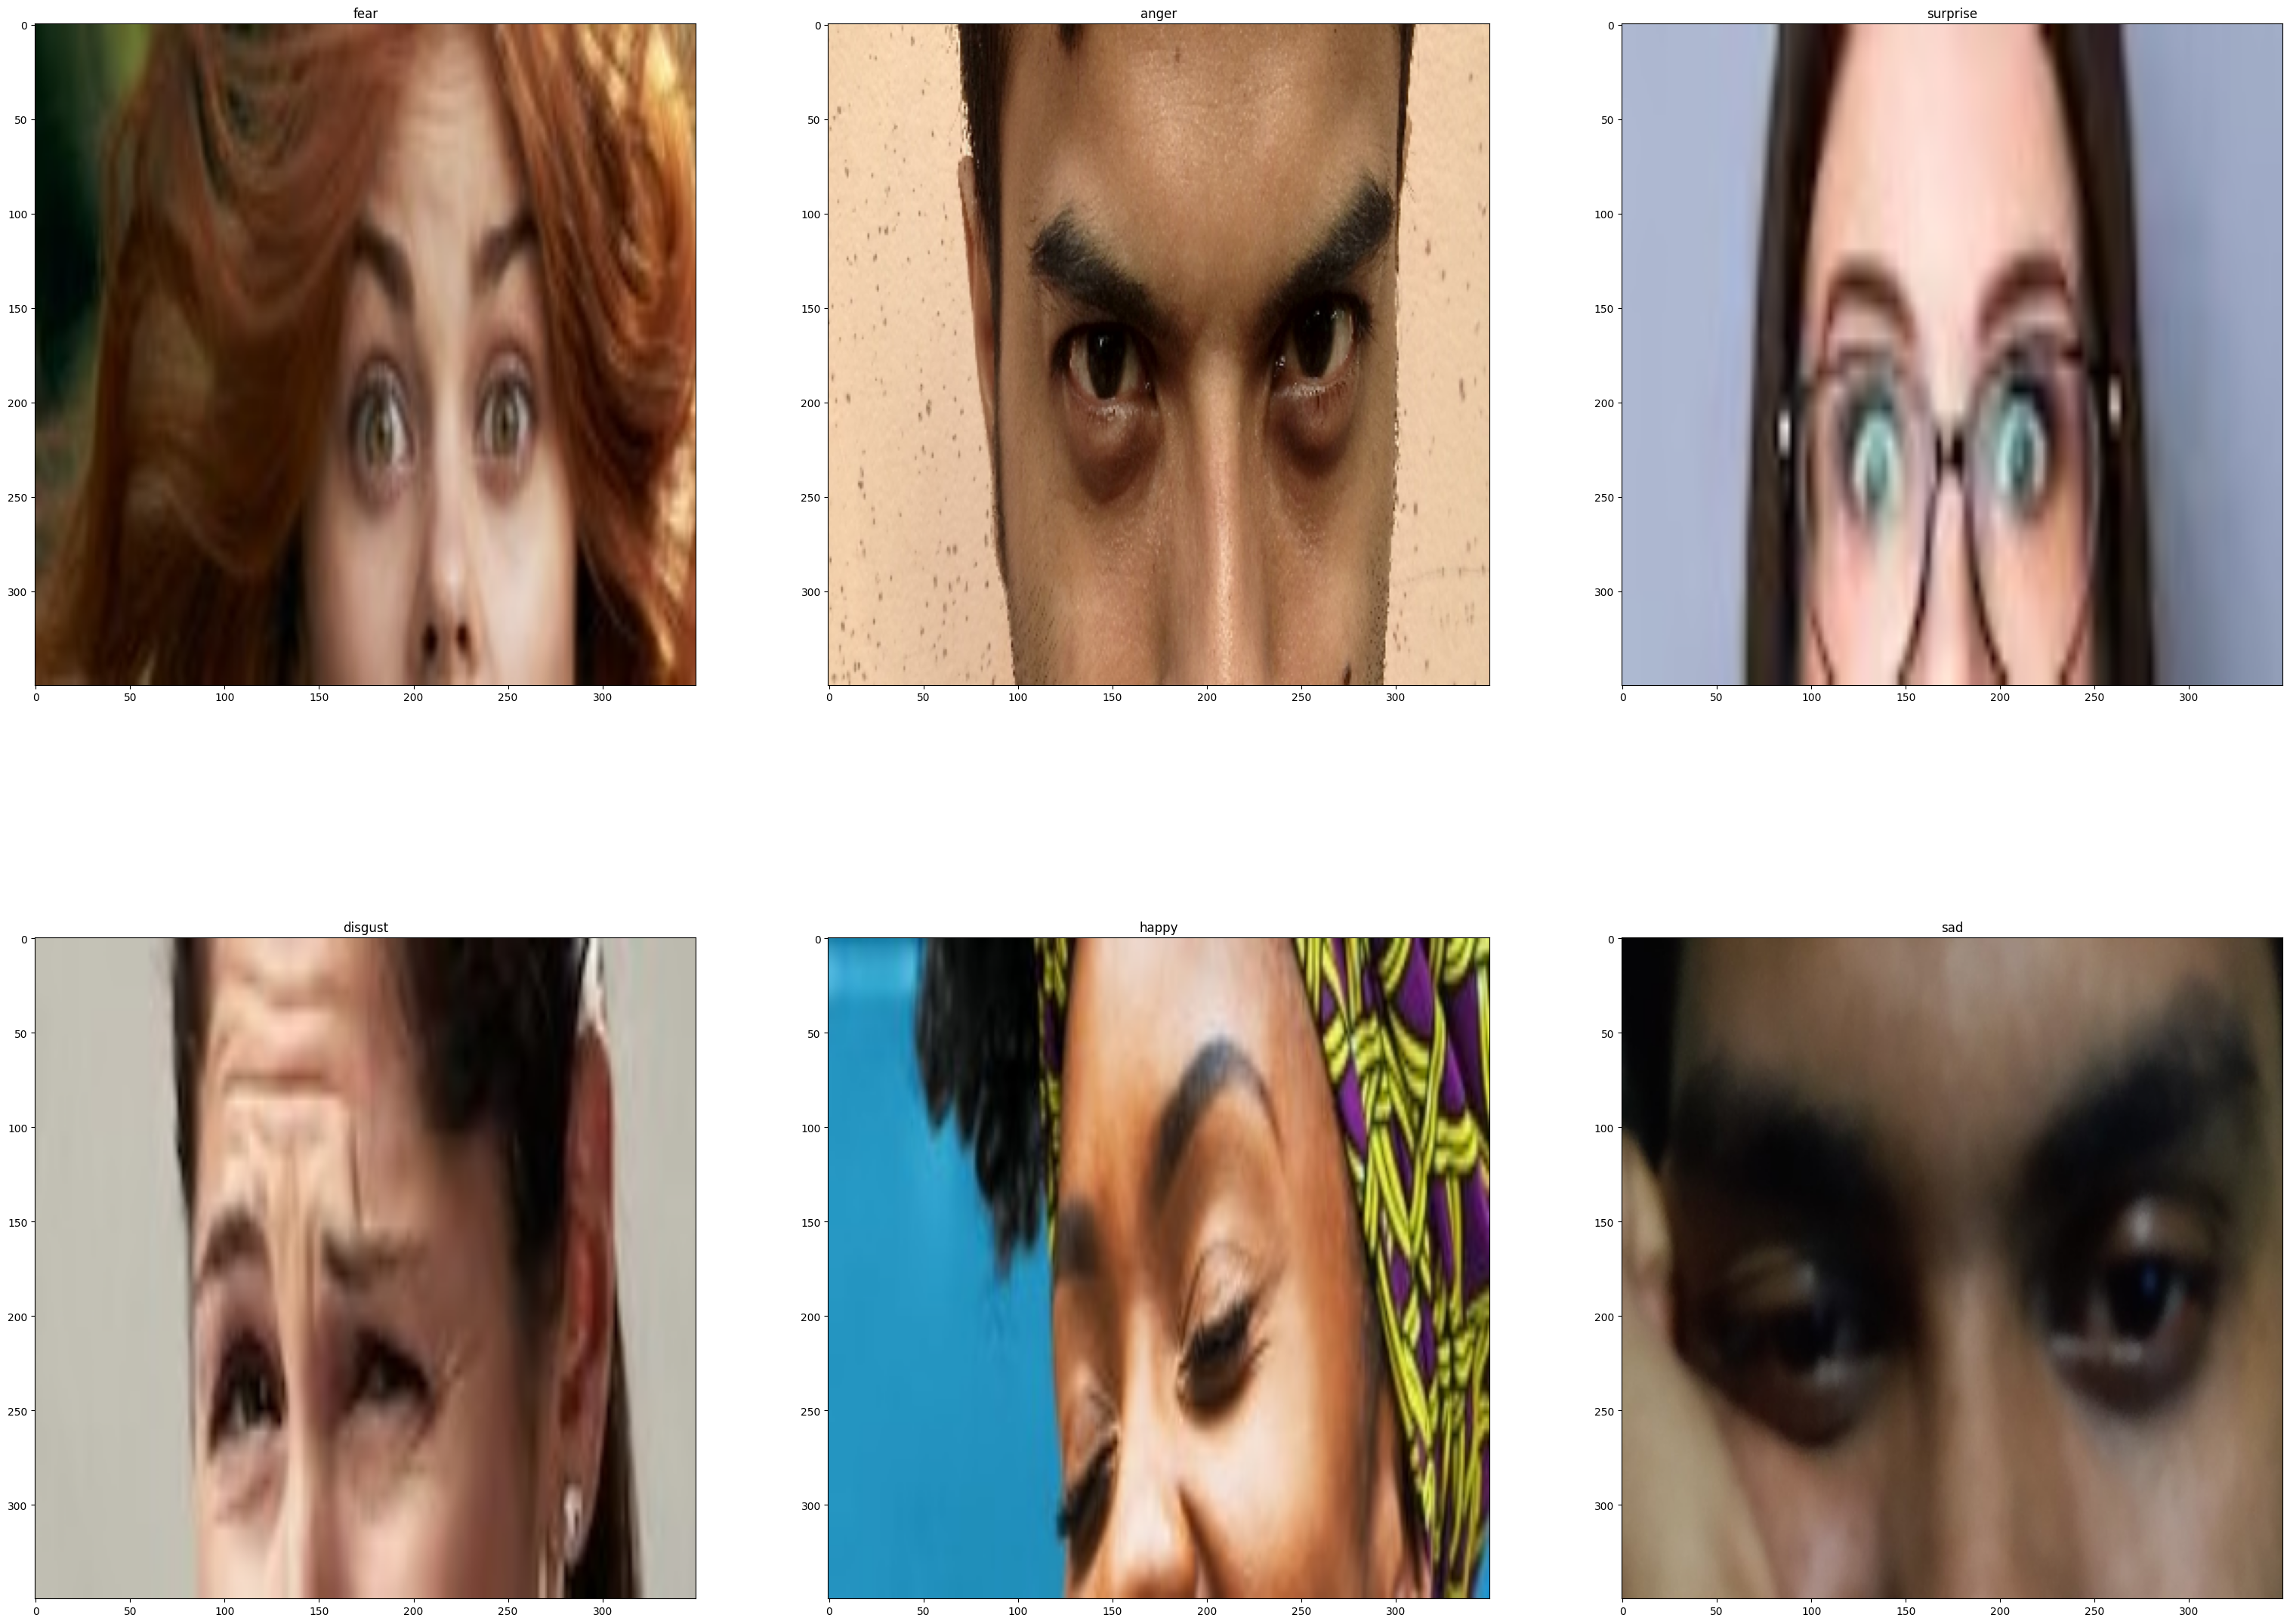

In [ ]:
def get_random_unique_sample(images,labels):
    l = []
    imgs = []
    labels_array = np.array(labels)
    uniq = list(np.unique(labels_array))
    while len(l)!=len(uniq):
        r = random.randint(0,len(images)-1)
        unknown = labels[r]
        if unknown not in l:
            l.append(labels[r])
            imgs.append(images[r])
    del labels_array
    del uniq
    return  imgs,l
def show_images(images, rows = 1, titles = None):
    assert((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(int(rows),int( np.ceil(n_images/float(rows))), n +1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
imgs,la = get_random_unique_sample(train_x,train_y)
show_images(imgs,titles=la,rows=2)

In [ ]:
train_y = np.array(train_y)
train_x = np.array(train_x)
test_y = np.array(test_y)
test_x = np.array(test_x)
encoder = LabelEncoder()
train_y = encoder.fit_transform(train_y)
train_y = to_categorical(train_y)
test_y = encoder.fit_transform(test_y)
test_y = to_categorical(test_y)
def get_features(pr_model, data,width=350):
    cnn_model = pr_model(include_top=False, input_shape=(width, width, 3), weights='imagenet')

    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)
    features = cnn_model.predict(data, batch_size=5, verbose=1)
    return features
width =350
inception_features = get_features(InceptionV3, train_x)
xception_features = get_features(Xception,train_x)
features = np.concatenate([inception_features, xception_features],axis=1)

In [ ]:
model = Sequential()
model.add(layers.Dense(1020,activation= "relu",input_shape= (features.shape[1],)))
model.add(layers.Dense(900,activation = "relu"))
model.add(layers.Dense(800,activation="relu"))
model.add(Dropout(0.5))
#model.add(layers.Dense(700,activation="relu"))
model.add(layers.Dense(6,activation="softmax"))
model.compile(optimizer = "adam" ,loss = "categorical_crossentropy" , metrics = ["accuracy"])
history = model.fit(features,train_y,batch_size = 5,epochs = 26)

Epoch 1/26
54/54 [==============================] - 5s 81ms/step - loss: 2.1888 - accuracy: 0.2444
Epoch 2/26
54/54 [==============================] - 5s 86ms/step - loss: 1.5148 - accuracy: 0.3926
Epoch 3/26
54/54 [==============================] - 4s 78ms/step - loss: 1.3300 - accuracy: 0.4889
Epoch 4/26
54/54 [==============================] - 4s 81ms/step - loss: 1.0637 - accuracy: 0.6074
Epoch 5/26
54/54 [==============================] - 5s 91ms/step - loss: 0.7830 - accuracy: 0.7333
Epoch 6/26
54/54 [==============================] - 4s 72ms/step - loss: 0.5435 - accuracy: 0.8037
Epoch 7/26
54/54 [==============================] - 4s 69ms/step - loss: 0.4813 - accuracy: 0.8407
Epoch 8/26
54/54 [==============================] - 4s 77ms/step - loss: 0.3678 - accuracy: 0.8852
Epoch 9/26
54/54 [==============================] - 5s 97ms/step - loss: 0.3381 - accuracy: 0.9000
Epoch 10/26
54/54 [==============================] - 4s 74ms/step - loss: 0.1894 - accuracy: 0.9185
Epoch 11/

In [ ]:
inception_features = get_features(InceptionV3,test_x)
xception_features = get_features(Xception,test_x)
features_test = np.concatenate([inception_features, xception_features],axis=1)

28/28 [==============================] - 83s 3s/step


In [ ]:
eva = model.evaluate(features_test,test_y)

5/5 [==============================] - 0s 17ms/step - loss: 0.9503 - accuracy: 0.7464


In [ ]:
model.save("/content/drive/MyDrive/eye reaction last/CNN_model.h5")

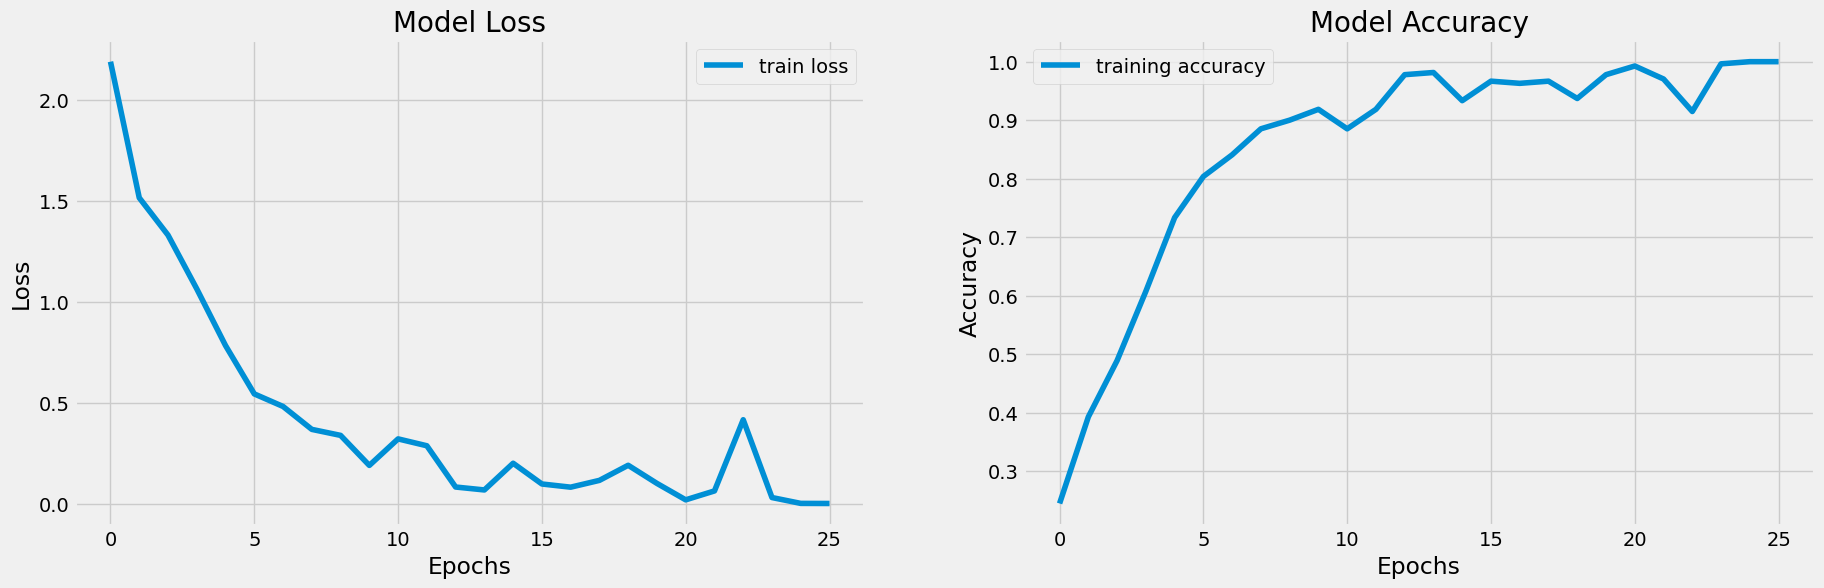

In [ ]:
plt.style.use("fivethirtyeight")
plt.figure(figsize = (20,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title("Model Loss",fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train loss', 'validation loss'], loc ='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.title("Model Accuracy",fontsize=20)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['training accuracy', 'validation accuracy'], loc ='best')
plt.show()

In [ ]:
pred = model.predict(features_test)
y_decode = np.argmax(pred,axis=1)
y_decode1 = encoder.inverse_transform(y_decode)

5/5 [==============================] - 0s 21ms/step


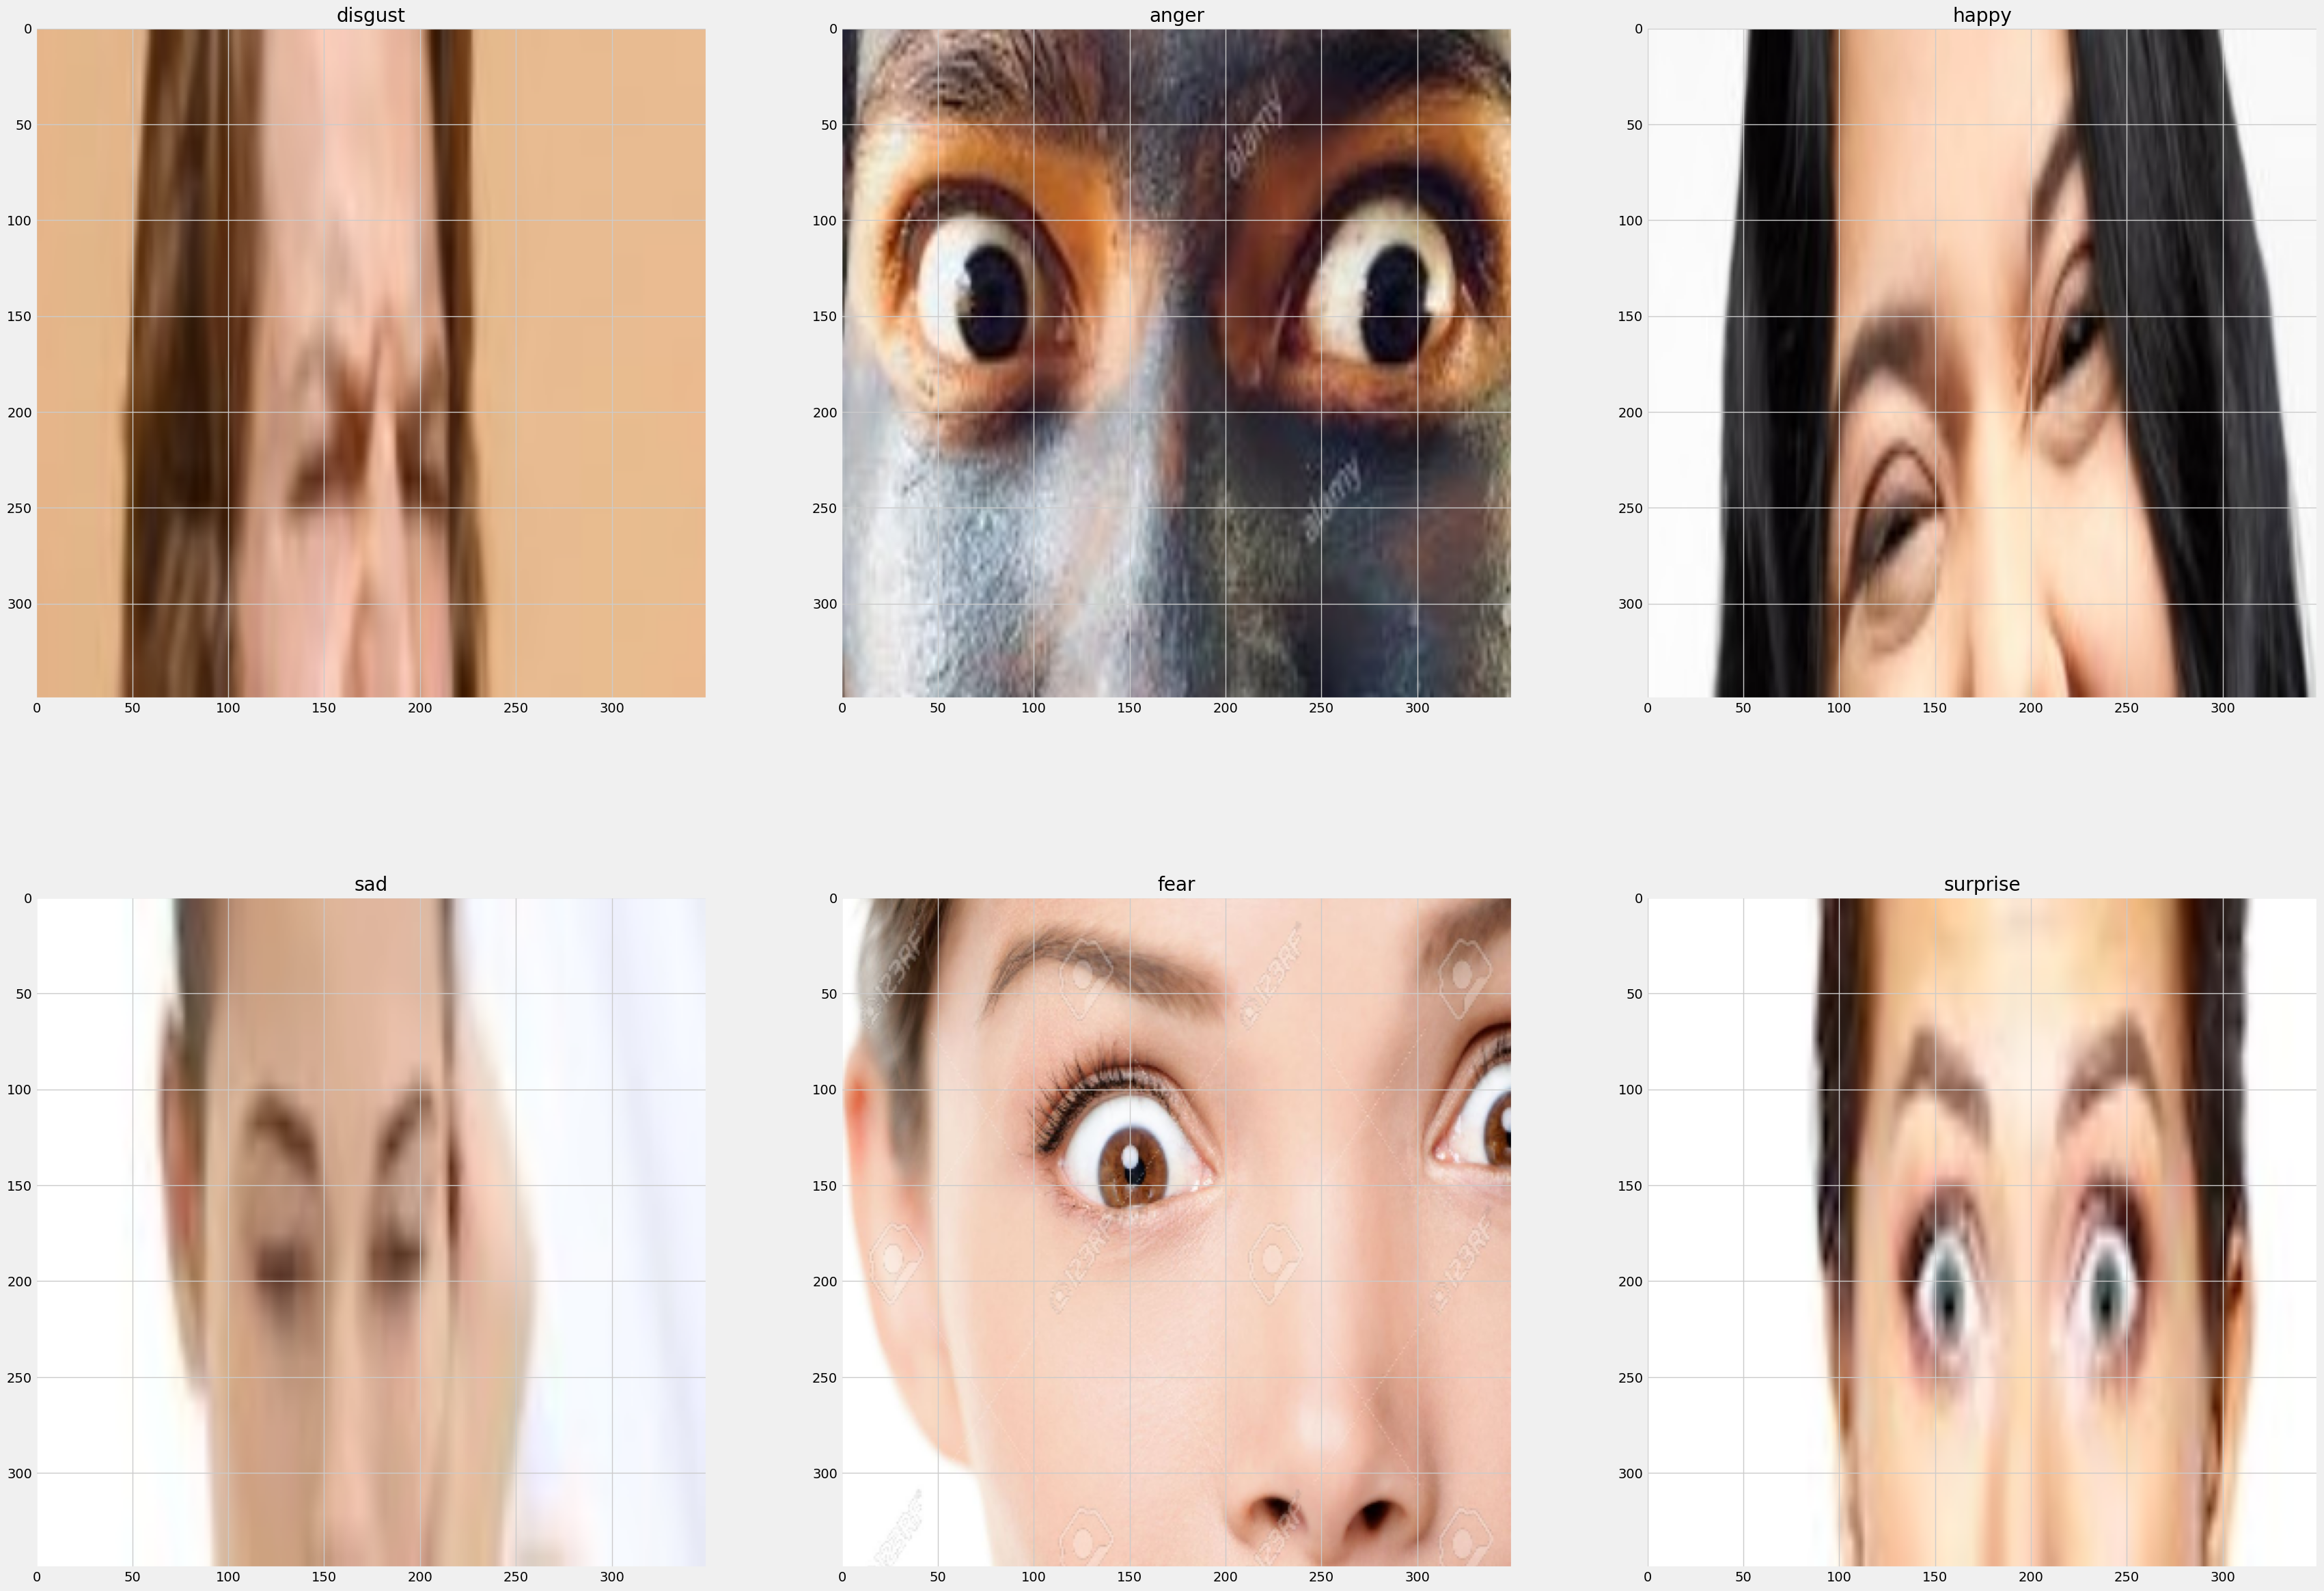

In [ ]:
#predicted Emotions
imgs,la = get_random_unique_sample(test_x,y_decode1)
show_images(imgs,titles=la,rows=2)